In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_excel
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse,aic

# Data Importing

In [4]:
Data=read_excel('C:/Users/vista/Desktop/GDP.xlsx', index_col="observation_date")
#TOALSL -> Total Consumer Credit Owned and Securitized, Billions of Dollars, Quarterly, Seasonally Adjusted
#GFDEBTN -> Federal Debt: Total Public Debt, Millions of Dollars, Quarterly, Not Seasonally Adjusted
Data.head(5)

,GDP,TOTALSL,GFDEBTN
observation_date,,,
1966-01-01,795.734,97.745157,320999
1966-04-01,804.981,99.299733,316097
1966-07-01,819.638,100.440197,324748
1966-10-01,833.302,101.392880,329319
1967-01-01,844.170,102.431100,330947


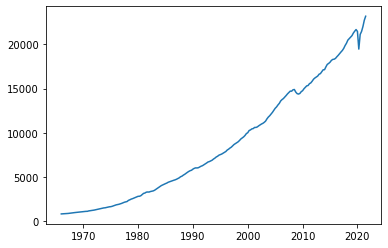

In [5]:
plt.plot(Data.GDP)
plt.show()

# Granjer Test

In [6]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test',verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag,verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [7]:
maxlag=7
test='ssr_chi2test'
from statsmodels.tsa.stattools import grangercausalitytests
grangers_causation_matrix(Data,variables=Data.columns)

,GDP_x,TOTALSL_x,GFDEBTN_x
GDP_y,1.0,0.3183,0.0000
TOTALSL_y,0.0,1.0000,0.0274
GFDEBTN_y,0.0,0.0000,1.0000


# Cointigration Test

In [8]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
def cointegration(df,alpha=0.05):
    out=coint_johansen(df,-1,5)
    d={'0.90':0 ,'0.95':1,'0.99':2}
    traces=out.lr1
    cvs=out.cvt[:,d[str(1-alpha)]]
    def adjust(val,length=6):return str(val).ljust(length)
    print('Name   :: test stat  > C(95%)  ==>  signif \n ','--'*30)
    for col,trace,cvt in zip(df.columns,traces,cvs):
        print(adjust(col), '::' ,adjust(round(trace,2),10), ">" ,adjust(round(cvt,2),8),"==>" ,trace>cvt)

In [9]:
cointegration(Data)

Name   :: test stat  > C(95%)  ==>  signif 
  ------------------------------------------------------------
GDP    :: 40.34      > 24.28    ==> True
TOTALSL :: 16.19      > 12.32    ==> True
GFDEBTN :: 5.07       > 4.13     ==> True


## همگی ترکیب های خطی روی متغیرها تعادل بلند مدت دارند

# Test for Staionary

In [10]:
Data_train=Data[0:-20]
Data_test=Data[-20:]

In [11]:
def ad_test(series,name='',signif=0.05,verbose=False):
    out=adfuller(series)
    p_value=round(out[1],4)
    print(f'adfuller test on "{name}"','\n','--'*30)
    if p_value<=signif:
        print(f'==> p_value={p_value} rejecting null hypothesis')
        print('==> series is stationary')
    else:
        print(f'==> p_value={p_value} can not reject the null hypothesis')
        print('==> series is non-stationary')

In [12]:
for name,column in Data_train.items():
    ad_test(column,name=column.name)
    print('\n')

adfuller test on "GDP" 
 ------------------------------------------------------------
==> p_value=1.0 can not reject the null hypothesis
==> series is non-stationary


adfuller test on "TOTALSL" 
 ------------------------------------------------------------
==> p_value=0.9991 can not reject the null hypothesis
==> series is non-stationary


adfuller test on "GFDEBTN" 
 ------------------------------------------------------------
==> p_value=1.0 can not reject the null hypothesis
==> series is non-stationary




## هر سه سری مانا نیستند

# doing Staionary by diffrencing

In [13]:
Data_differenced=Data_train.diff().dropna()
for name,column in Data_differenced.items():
    ad_test(column,name=column.name)
    print('\n')

adfuller test on "GDP" 
 ------------------------------------------------------------
==> p_value=0.0007 rejecting null hypothesis
==> series is stationary


adfuller test on "TOTALSL" 
 ------------------------------------------------------------
==> p_value=0.0089 rejecting null hypothesis
==> series is stationary


adfuller test on "GFDEBTN" 
 ------------------------------------------------------------
==> p_value=0.7686 can not reject the null hypothesis
==> series is non-stationary




In [14]:
Data_differenced=Data_differenced.diff().dropna()
for name,column in Data_differenced.items():
    ad_test(column,name=column.name)
    print('\n')

adfuller test on "GDP" 
 ------------------------------------------------------------
==> p_value=0.0 rejecting null hypothesis
==> series is stationary


adfuller test on "TOTALSL" 
 ------------------------------------------------------------
==> p_value=0.0 rejecting null hypothesis
==> series is stationary


adfuller test on "GFDEBTN" 
 ------------------------------------------------------------
==> p_value=0.0 rejecting null hypothesis
==> series is stationary




## هر سه سری بعد از دو بار تفاضل گیری مانا شد.

# VAR Model Creation

In [16]:
model=VAR(Data_differenced)
model_fitted=model.fit(5)
model_fitted.summary()

C:\Users\vista\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 18, Feb, 2022
Time:                     14:25:36
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    36.6036
Nobs:                     196.000    HQIC:                   36.1258
Log likelihood:          -4294.81    FPE:                3.53636e+15
AIC:                      35.8008    Det(Omega_mle):     2.79458e+15
--------------------------------------------------------------------
Results for equation GDP
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              2.464528         4.151054            0.594           0.553
L1.GDP            -0.578877         0.077368           -7.482           0.000
L1.TOTALSL        -0.048382         0.339020           -0.143           0.

In [17]:
for i in range(1,8):
    result=model.fit(i)
    print('AIC in i=',i,'is:',result.aic)

AIC in i= 1 is: 36.5152837516429
AIC in i= 2 is: 36.08941571132118
AIC in i= 3 is: 35.88623363529654
AIC in i= 4 is: 35.90690066685575
AIC in i= 5 is: 35.80078081828135
AIC in i= 6 is: 35.71946025823256
AIC in i= 7 is: 35.728461800102


# Checking  Model Residuals by Durbin_Watson test

In [18]:
from statsmodels.stats.stattools import durbin_watson
out=durbin_watson(model_fitted.resid)
for col,val in zip(Data_differenced.columns,out):
    print(col,':',round(val,2))

GDP : 2.02
TOTALSL : 2.13
GFDEBTN : 1.99


### it is OK in lag = 5; We do not have Corrolation in Residuals in any series models

In [19]:
lag_order=model_fitted.k_ar
lag_order

5

# Forecasting by Model

In [20]:
fc_input=Data_differenced.values[-lag_order:]
fc=model_fitted.forecast(y=fc_input,steps=20)
fc

array([[-1.66722539e+02, -5.00449936e+01,  4.15012495e+05],
       [ 5.93110872e+01,  1.57119450e+01, -2.75733041e+05],
       [ 1.27244327e+02,  1.69426090e+01, -1.62724638e+05],
       [-9.71181249e+01, -6.29856458e-02,  1.30530908e+05],
       [-3.00524520e+01, -2.09267877e+01,  1.80662706e+05],
       [ 3.72046388e+01, -1.98175275e+00, -1.10203717e+05],
       [ 3.64491427e+01,  2.23405588e+01, -1.15201255e+05],
       [-1.90284954e+01, -1.49846438e+00,  3.81517175e+04],
       [-3.69125171e+01, -1.64717817e+01,  1.41035665e+05],
       [ 1.30303793e+01,  4.40648195e+00, -5.99300327e+04],
       [ 3.76901729e+01,  9.75742917e+00, -8.71666139e+04],
       [-1.86011952e+01, -1.39461257e+00,  3.47134308e+04],
       [-2.10788354e+01, -7.65585401e+00,  8.10932076e+04],
       [ 1.05153258e+01,  4.48932029e-01, -2.87795652e+04],
       [ 1.83395812e+01,  6.83887422e+00, -5.31014895e+04],
       [-6.03982944e+00, -8.40094391e-05,  1.41934573e+04],
       [-1.39402359e+01, -5.38565123e+00

In [22]:
Data_forecast=pd.DataFrame(fc,index=Data.index[-20:],columns=Data.columns+'_fc')
Data_forecast.index = Data.index[-20:]
print(Data_forecast)

                      GDP_fc  TOTALSL_fc     GFDEBTN_fc
observation_date                                       
2016-10-01       -166.722539  -50.044994  415012.495465
2017-01-01         59.311087   15.711945 -275733.040959
2017-04-01        127.244327   16.942609 -162724.637816
2017-07-01        -97.118125   -0.062986  130530.908289
2017-10-01        -30.052452  -20.926788  180662.706215
2018-01-01         37.204639   -1.981753 -110203.717174
2018-04-01         36.449143   22.340559 -115201.254659
2018-07-01        -19.028495   -1.498464   38151.717543
2018-10-01        -36.912517  -16.471782  141035.665194
2019-01-01         13.030379    4.406482  -59930.032726
2019-04-01         37.690173    9.757429  -87166.613895
2019-07-01        -18.601195   -1.394613   34713.430825
2019-10-01        -21.078835   -7.655854   81093.207565
2020-01-01         10.515326    0.448932  -28779.565192
2020-04-01         18.339581    6.838874  -53101.489482
2020-07-01         -6.039829   -0.000084   14193

# Removing Differencing Effect in Forecasted Value

In [23]:
def transformation(df_train,df_forecast,second_diff=False):
    df_fc=df_forecast.copy()
    columns=df_train.columns
    for col in columns:
        if second_diff:
            df_fc[str(col)+'_1d']=df_fc[str(col)+'_fc'].cumsum()+(df_train[col].iloc[-1]-df_train[col].iloc[-2])
        df_fc[str(col)+'_forecast']=df_train[col].iloc[-1]+df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [24]:
Data_final=transformation(Data_train,Data_forecast,second_diff=True)
Data_final.index = Data.index[-20:]
print(Data_final)

                      GDP_fc  TOTALSL_fc     GFDEBTN_fc      GDP_1d  \
observation_date                                                      
2016-10-01       -166.722539  -50.044994  415012.495465   -2.880539   
2017-01-01         59.311087   15.711945 -275733.040959   56.430548   
2017-04-01        127.244327   16.942609 -162724.637816  183.674875   
2017-07-01        -97.118125   -0.062986  130530.908289   86.556750   
2017-10-01        -30.052452  -20.926788  180662.706215   56.504298   
2018-01-01         37.204639   -1.981753 -110203.717174   93.708937   
2018-04-01         36.449143   22.340559 -115201.254659  130.158079   
2018-07-01        -19.028495   -1.498464   38151.717543  111.129584   
2018-10-01        -36.912517  -16.471782  141035.665194   74.217067   
2019-01-01         13.030379    4.406482  -59930.032726   87.247446   
2019-04-01         37.690173    9.757429  -87166.613895  124.937619   
2019-07-01        -18.601195   -1.394613   34713.430825  106.336424   
2019-1

In [25]:
Data_final.loc[:,['GDP_forecast','TOTALSL_forecast','GFDEBTN_forecast']]

,GDP_forecast,TOTALSL_forecast,GFDEBTN_forecast
observation_date,,,
2016-10-01,18772.578461,3565.781273,2.018031e+07
2017-01-01,18829.009008,3588.998315,2.051144e+07
2017-04-01,19012.683883,3629.157965,2.067985e+07
2017-07-01,19099.240633,3669.254630,2.097879e+07
2017-10-01,19155.744931,3688.424507,2.145840e+07
2018-01-01,19249.453868,3705.612631,2.182779e+07
2018-04-01,19379.611947,3745.141314,2.208199e+07
2018-07-01,19490.741531,3783.171533,2.237434e+07
2018-10-01,19564.958598,3804.729970,2.280773e+07


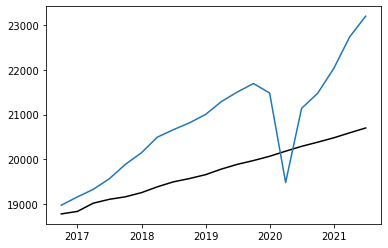

In [26]:
plt.plot(Data_final['GDP_forecast'], color = 'black')
plt.plot(Data_test['GDP'])

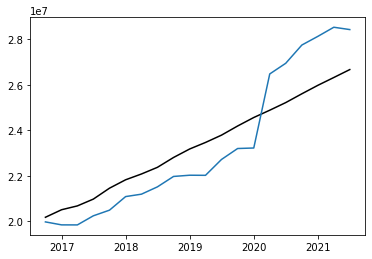

In [28]:
plt.plot(Data_final['GFDEBTN_forecast'], color = 'black')
plt.plot(Data_test['GFDEBTN'])

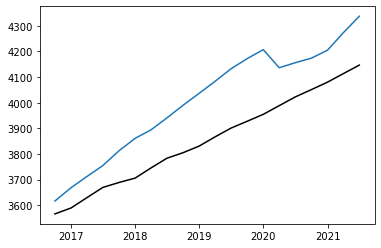

In [29]:
plt.plot(Data_final['TOTALSL_forecast'], color = 'black')
plt.plot(Data_test['TOTALSL'])